<a href="https://colab.research.google.com/github/EzraFell2/User-Journey-Analysis-using-GA4-and-BigQuery/blob/main/JOBS_FINDING_T%C3%8CM_VI%E1%BB%86C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ga4-468103-3f381e69d384.json to ga4-468103-3f381e69d384.json


In [ ]:
!pip install --upgrade google-analytics-data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install --quiet google-cloud-bigquery pandas

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account

KEY_PATH = "/content/ga4-468103-3f381e69d384.json"
credentials = service_account.Credentials.from_service_account_file(KEY_PATH)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

print("Đã kết nối thành công đến BigQuery Project:", credentials.project_id)


Đã kết nối thành công đến BigQuery Project: ga4-468103


In [ ]:
from google.cloud import bigquery
# Sử dụng credentials đã load từ file JSON
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# **A/ JOBS FINDING - TÌM VIỆC**

**I. CHUẨN BỊ DỮ LIỆU - TRUY VẤN**

---



In [ ]:
query_job_finding_events = """
WITH events AS (
  SELECT
    user_pseudo_id,
    TIMESTAMP_MICROS(event_timestamp) AS event_datetime,           -- full datetime
    DATE(TIMESTAMP_MICROS(event_timestamp)) AS event_date,         -- chỉ lấy ngày
    event_timestamp, -- Add event_timestamp here
    event_name,
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key='page_location') AS page_location,
    traffic_source.source AS source,
    traffic_source.medium AS medium
  FROM `ga4-468103.analytics_470202691.events_intraday_*`
  WHERE _TABLE_SUFFIX BETWEEN '20250901' AND '20250915'
),
ordered AS (
  SELECT
    *,
    LAG(page_location) OVER (PARTITION BY user_pseudo_id ORDER BY event_datetime) AS prev_page,
    LAG(event_name) OVER (PARTITION BY user_pseudo_id ORDER BY event_datetime) AS prev_event
  FROM events
)
SELECT
  user_pseudo_id,
  event_datetime,
  page_location,
  prev_page,
  prev_event,
  source, medium
FROM ordered
WHERE REGEXP_CONTAINS(LOWER(page_location), r'/viec-lam/')  -- điều chỉnh pattern
ORDER BY event_datetime DESC
"""

In [ ]:
df_job_finding_events = client.query(query_job_finding_events).to_dataframe()
print(df_job_finding_events.head())

         user_pseudo_id                   event_datetime  \
0  647066665.1756969319 2025-09-15 16:59:44.399361+00:00   
1  647066665.1756969319 2025-09-15 16:59:35.405448+00:00   
2  647066665.1756969319 2025-09-15 16:59:29.758309+00:00   
3  482044706.1757921855 2025-09-15 16:58:59.706623+00:00   
4  482044706.1757921855 2025-09-15 16:58:54.450542+00:00   

                                       page_location  \
0  https://www.fidovn.com/viec-lam/chuyen-vien-me...   
1  https://www.fidovn.com/viec-lam/chuyen-vien-me...   
2  https://www.fidovn.com/viec-lam/chuyen-vien-me...   
3  https://www.fidovn.com/viec-lam/tuyen-hoc-vien...   
4  https://www.fidovn.com/viec-lam/tuyen-hoc-vien...   

                                           prev_page       prev_event  source  \
0  https://www.fidovn.com/viec-lam/chuyen-vien-me...          gtm.dom  google   
1  https://www.fidovn.com/viec-lam/chuyen-vien-me...        page_view  google   
2  https://www.fidovn.com/viec-lam/nhan-vien-medi...  user_

In [ ]:
df_job_finding_events.to_csv('job_finding_events.csv', index=False)
files.download('job_finding_events.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
query_source_medium = """
SELECT source, medium, COUNT(DISTINCT user_pseudo_id) AS users_to_job
FROM (
  SELECT user_pseudo_id,
         (SELECT value.string_value FROM UNNEST(event_params) WHERE key='page_location') AS page_location,
         traffic_source.source AS source,
         traffic_source.medium AS medium
  FROM `ga4-468103.analytics_470202691.events_intraday_*`
  WHERE _TABLE_SUFFIX BETWEEN '20250901' AND '20250915'
)
WHERE REGEXP_CONTAINS(LOWER(page_location), r'/viec-lam/')
GROUP BY source, medium
ORDER BY users_to_job DESC
LIMIT 20;
"""
df_source_medium = client.query(query_source_medium).to_dataframe()
print(df_source_medium.head())

     source   medium  users_to_job
0      None     None         15942
1    google      cpc          2843
2        FB     paid           410
3  (direct)   (none)           352
4    google  organic           278


In [ ]:
query_job_funnel = """
SELECT
  user_pseudo_id,
  ARRAY_AGG(
    (SELECT value.string_value
     FROM UNNEST(event_params)
     WHERE key = 'page_location')
    ORDER BY event_timestamp
  ) AS path
FROM `ga4-468103.analytics_470202691.events_intraday_*`
WHERE _TABLE_SUFFIX BETWEEN '20250901' AND '20250915'
  AND (
        REGEXP_CONTAINS(
          (SELECT value.string_value
           FROM UNNEST(event_params)
           WHERE key = 'page_location'),
          r'/viec-lam'
        )
        OR
        (SELECT value.string_value
         FROM UNNEST(event_params)
         WHERE key = 'page_location') = 'https://www.fidovn.com/'
      )
GROUP BY user_pseudo_id;
"""

df_job_funnel = client.query(query_job_funnel).to_dataframe()
print(df_job_funnel.head())

         user_pseudo_id                                               path
0   57507064.1756827462  [https://www.fidovn.com/viec-lam?utm_source=FB...
1  873794729.1756067734  [https://www.fidovn.com/viec-lam?utm_source=FB...
2  230160356.1756829734  [https://www.fidovn.com/viec-lam?utm_source=FB...
3  356579109.1756830712  [https://www.fidovn.com/tim-kiem/viec-lam-ban-...
4  208571624.1756820914  [https://www.fidovn.com/viec-lam?gad_source=1&...


II. LÀM SẠCH DỮ LIỆU URL (PAGE PATH)

---



In [ ]:
import pandas as pd
import re

# Loại bỏ query string (?...) và anchor (#...)
def clean_url(url):
    if url is None:
        return None
    return re.split(r'[\?#]', url)[0]

# Áp dụng vào DataFrame events
df_job_finding_events['clean_page'] = df_job_finding_events['page_location'].apply(clean_url)
df_job_funnel['clean_path'] = df_job_funnel['path'].apply(lambda arr: [clean_url(p) for p in arr])

In [ ]:
import re

def categorize_page(url):
    if url is None:
        return "Unknown"

    elif clean_url in ["https://www.fidovn.com", "https://fidovn.com"]:
        return "Homepage"

    elif re.fullmatch(r'https://www\.fidovn\.com/viec-lam/?', url):
        return "Job List"

    elif re.match(r'https://www\.fidovn\.com/viec-lam/.+', url):
        return "Job Detail"

    else:
        return "Other"

df_job_finding_events['page_category'] = df_job_finding_events['clean_page'].apply(categorize_page)

**III. TRỰC QUAN HÓA DỮ LIỆU**

---



**Nguồn Traffic dẫn đến Job Pages (Các trang tìm việc)**


In [ ]:
import plotly.express as px
import pandas as pd

df_sorted = df_source_medium.sort_values("users_to_job", ascending=False)

# Lấy top 5
top5 = df_sorted.head(5)

# Gộp Others
others = pd.DataFrame({
    "label": ["Others"],
    "users_to_job": [df_sorted["users_to_job"].iloc[5:].sum()]
})
df_final = pd.concat([top5, others], ignore_index=True)
fig = px.pie(
    df_final,
    names="label",
    values="users_to_job",
    title="Nguồn traffic dẫn đến Job Pages (Top 5 + Others)",
    hole=0.4,
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(textinfo="percent+label", pull=[0.05]*len(df_final))
fig.update_layout(
    width=600,
    height=500,
)

fig.show()


**Funnel chart: Homepage → Job List → Job Detail**

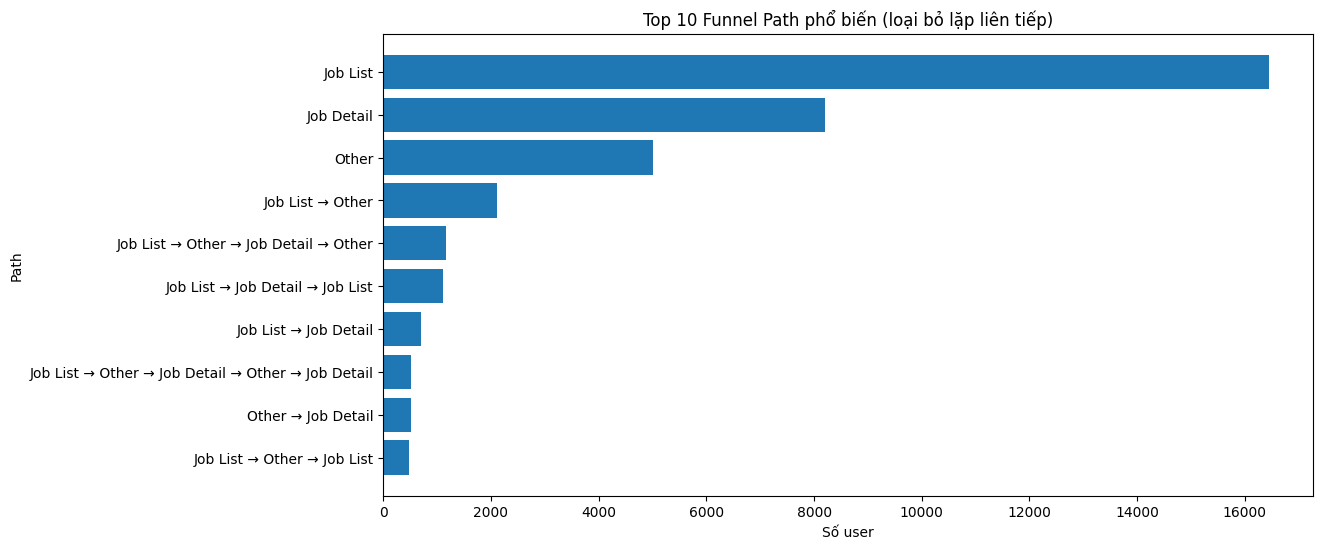

In [ ]:
from collections import Counter

# Gom tất cả sequence
all_paths = []
for path in df_job_funnel['clean_path']:
    cats = [categorize_page(p) for p in path]

    # Loại bỏ các bước lặp liên tiếp
    deduped = [cats[i] for i in range(len(cats)) if i == 0 or cats[i] != cats[i-1]]

    all_paths.append(" → ".join(deduped))

# Đếm tần suất các sequence
counter = Counter(all_paths)
df_funnel = pd.DataFrame(counter.items(), columns=["Path", "Count"]).sort_values("Count", ascending=False).head(10)

# Vẽ bar chart
plt.figure(figsize=(12,6))
plt.barh(df_funnel["Path"], df_funnel["Count"])
plt.title("Top 10 Funnel Path phổ biến (loại bỏ lặp liên tiếp)")
plt.xlabel("Số user")
plt.ylabel("Path")
plt.gca().invert_yaxis()
plt.show()

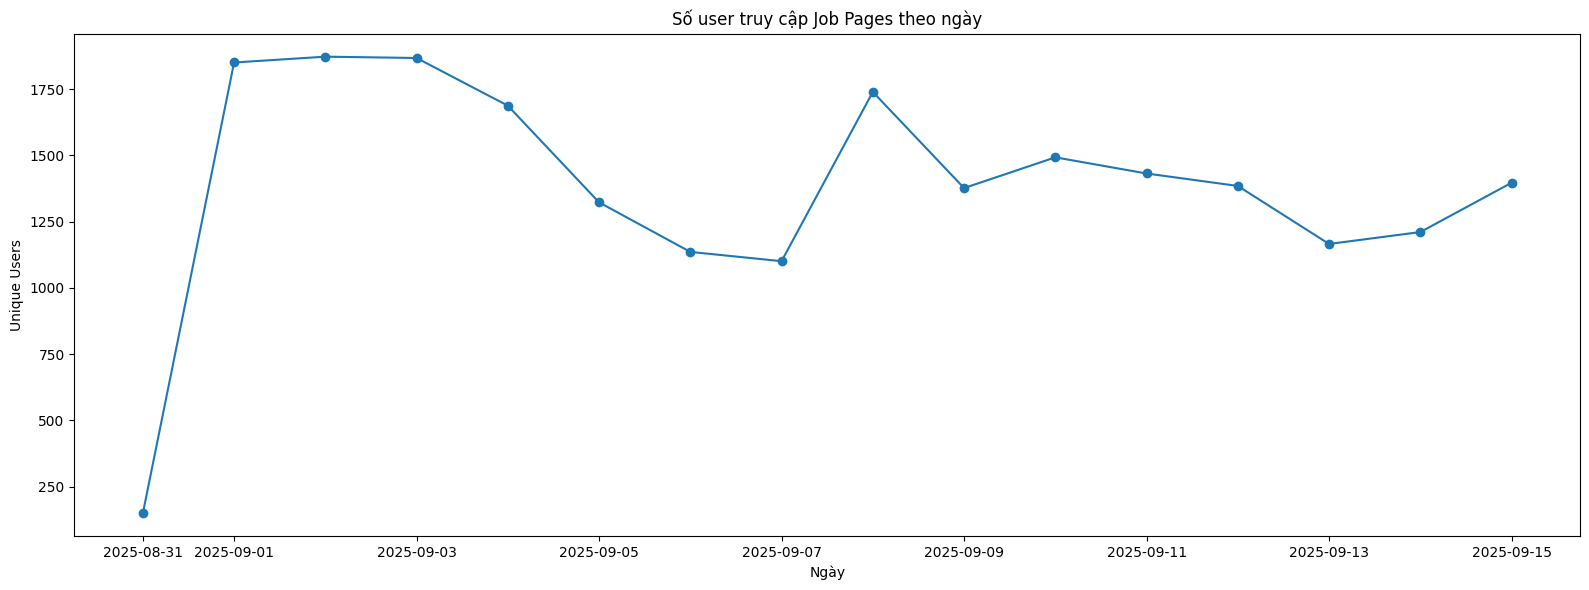

In [ ]:
df_job_finding_events['event_date'] = pd.to_datetime(df_job_finding_events['event_datetime']).dt.date
df_daily = df_job_finding_events.groupby('event_date')['user_pseudo_id'].nunique().reset_index()

plt.figure(figsize=(16,6))
plt.plot(df_daily['event_date'], df_daily['user_pseudo_id'], marker='o')
plt.title("Số user truy cập Job Pages theo ngày")
plt.xlabel("Ngày")
plt.ylabel("Unique Users")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

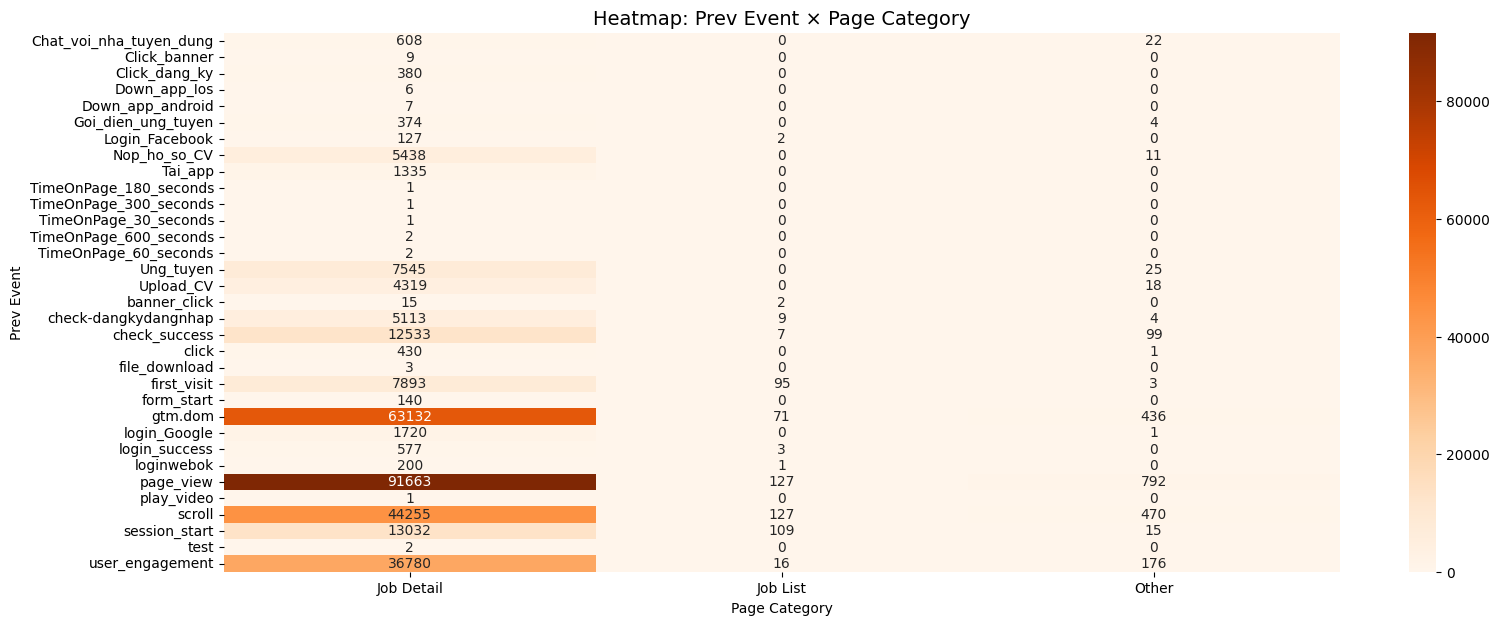

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gom nhóm dữ liệu theo prev_event và page_category
df_prev = df_job_finding_events.groupby(
    ['prev_event','page_category']
).size().reset_index(name='count')

# Pivot để vẽ heatmap
pivot_prev = df_prev.pivot_table(
    index='prev_event',
    columns='page_category',
    values='count',
    fill_value=0
)

plt.figure(figsize=(18,7))
sns.heatmap(pivot_prev, annot=True, fmt=".0f", cmap="Oranges")
plt.title("Heatmap: Prev Event × Page Category", fontsize=14)
plt.xlabel("Page Category")
plt.ylabel("Prev Event")
plt.show()